## 0. Libarary 불러오기 및 경로설정

In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [2]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [3]:
from facenet_pytorch import MTCNN
from PIL import Image

mtcnn = MTCNN()

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])
        boxes, probs = mtcnn.detect(image)
        if boxes is None:
            img_width = 384
            img_height = 512
            crop_width = 224
            crop_height = 224
            boxes = [[img_width / 2 - crop_width / 2, img_height / 2 - crop_height / 2,
                    img_width / 2 + crop_width / 2, img_height / 2 + crop_height / 2]]
        image = image.crop(boxes[0])
        if self.transform:
            image = self.transform(image=np.array(image))['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [4]:
from albumentations import *
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import timm

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = Compose([
    Resize(384, 384, p=1.0),
    ToTensorV2(),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model_age = timm.create_model('efficientnet_b0', pretrained=False, num_classes=3).to(device)
model_age.load_state_dict(torch.load('/opt/ml/code/results/Age/004_accuracy_91.64%_f1_0.89.ckpt'))
model_age.eval()
model_gender = timm.create_model('efficientnet_b0', pretrained=False, num_classes=2).to(device)
model_gender.load_state_dict(torch.load('/opt/ml/code/results/Gender/003_accuracy_97.58%_f1_0.98.ckpt'))
model_gender.eval()
model_mask = timm.create_model('efficientnet_b0', pretrained=False, num_classes=3).to(device)
model_mask.load_state_dict(torch.load('/opt/ml/code/results/Mask/001_accuracy_99.87%_f1_ 1.0.ckpt'))
model_mask.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for i, images in tqdm(enumerate(loader)):
    with torch.no_grad():
        print(len(images))
        images = images.to(device)
        pred_age = model_age(images.float())
        pred_age = pred_age.argmax(dim=-1)
        pred_gender = model_gender(images.float())
        pred_gender = pred_gender.argmax(dim=-1)
        pred_mask = model_mask(images.float())
        pred_mask = pred_mask.argmax(dim=-1)
        pred = pred_mask * 6 + pred_gender * 3 + pred_age
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

NameError: name 'tqdm_notebook' is not defined

In [16]:
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)

In [13]:
a = np.array([1, 2, 3, 1, 2])
b = np.array([0, 4, 2, 1, 6])
c = np.array([3, 3, 2, 3, 5])

d = (a * 6 + b * 3 + c)
print(d)

[ 9 27 26 12 35]


test inference is done!


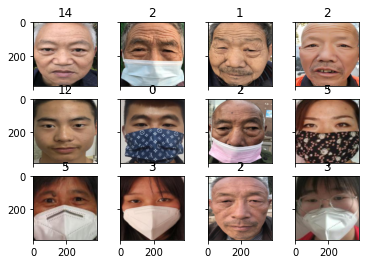

In [14]:
from albumentations import *
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import timm
import matplotlib.pyplot as plt

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
image_paths = image_paths[:12]
transform = Compose([
    Resize(384, 384, p=1.0),
    ToTensorV2(),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model_age = timm.create_model('efficientnet_b0', pretrained=False, num_classes=3).to(device)
model_age.load_state_dict(torch.load('/opt/ml/code/results/Age/004_accuracy_91.64%_f1_0.89.ckpt'))
model_age.eval()
model_gender = timm.create_model('efficientnet_b0', pretrained=False, num_classes=2).to(device)
model_gender.load_state_dict(torch.load('/opt/ml/code/results/Gender/003_accuracy_97.58%_f1_0.98.ckpt'))
model_gender.eval()
model_mask = timm.create_model('efficientnet_b0', pretrained=False, num_classes=3).to(device)
model_mask.load_state_dict(torch.load('/opt/ml/code/results/Mask/001_accuracy_99.87%_f1_ 1.0.ckpt'))
model_mask.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.

fig, axes = plt.subplots(3, 4, sharex=True, sharey=True)
all_predictions = []
loader = iter(loader)
for i in range(12):
    with torch.no_grad():
        images = next(loader)
        axes[i // 4][i % 4].imshow(images.squeeze(dim=0).permute(1, 2, 0))
        images = images.to(device)
        pred_age = model_age(images.float())
        pred_age = pred_age.argmax(dim=-1)
        pred_gender = model_gender(images.float())
        pred_gender = pred_gender.argmax(dim=-1)
        pred_mask = model_mask(images.float())
        pred_mask = pred_mask.argmax(dim=-1)
        pred = pred_mask * 6 + pred_gender * 3 + pred_age
        axes[i // 4][i % 4].set_title(pred.item())

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')